In [58]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

RANDOM_SEED = 2023

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')


X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## What's the shape of the data

Here MNIST is a set of 70,000 images each 28 X 28 pixels.

The target labels (y) are the actual number that each image represents.

In [43]:
print(X)
print(X.shape)
print(y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)
(70000,)


## View one digit of the set

1. Grab one of the records, each one being an image
2. Reshape it to 28 x 28
3. Plot using `plt.imshow()`

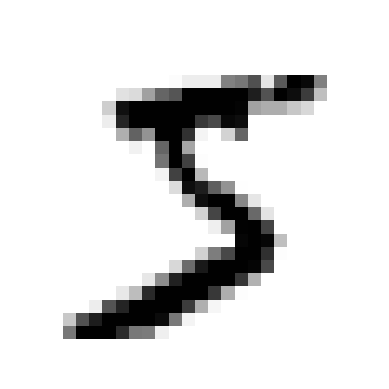

The image label: 5


In [44]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

some_digit = X[0] # first image
plot_digit(some_digit)
plt.show()

print(f'The image label: {y[0]}')

## Now split the data into train and test sets
This set is already pre-shuffled and split into training sets (first 60000) and test sets (10000)


In [45]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Try SVC for multi_classification

SVC natively handles binary classification

If fed a multiclass data set it uses the one-vs-one scheme

In [46]:
svm_clf = SVC(random_state=RANDOM_SEED)
svm_clf.fit(X_train[:2000], y_train[:2000])

some_digit_pred = svm_clf.predict([some_digit])
print(some_digit_pred)

['5']


### SVC scores

The model returns one score for each class, in this case 10

We can see the classes that the model is trained on, and the corresponding scores for our '5' digit

The score for the 5th class is 9.3 which is the highest

In [47]:
print(svm_clf.classes_)

some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
[[ 3.79297828  0.72949369  6.06184129  8.29800527 -0.29383983  9.30157597
   1.74723215  2.77365456  7.20601456  4.82245092]]


In [48]:
class_id = some_digit_scores.argmax()
print(svm_clf.classes_[class_id])

5


## Exercise: Try to build a classifier that achievers over 97% accuracy for the MNIST dataset

Here we'll use KNeighborsClassifier and use grid search to check for best hyperparams

In [49]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

knn_digit_pred = knn_clf.predict([some_digit])
print(knn_digit_pred)

['5']


Perform basic accuracy scoring of knn using cross validation.

In [50]:
# knn_cv_score = cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
# print(knn_cv_score)

Here Knn performs pretty well outside of the box, close to 97% but not quite.

We'll perform grid search cross validation to tune the model and hopefully get a bit better performance.

In [55]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))

params = { "weights": ['uniform', 'distance'], "n_neighbors": [4] }
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
knn_clf2 = KNeighborsClassifier()
grid_clf = GridSearchCV(estimator=knn_clf2, param_grid=params, cv=cv, n_jobs=-1)

grid_clf.fit(X_train, y_train)
print(grid_clf.best_params_)

print(grid_clf.best_score_)


{'n_neighbors': 4, 'weights': 'distance'}
0.9725333333333334


Looks like n_neighbors = 4 and weights = 'distance' provides a decent score of > 97%

Next we'll plot the confusion matrix of the best estimator and see the errors for all 10 classes.

In [56]:
knn_best_clf = grid_clf.best_estimator_
y_train_pred = cross_val_predict(knn_best_clf, X_train, y_train, cv=3)
print(y_train_pred.shape)

(60000,)


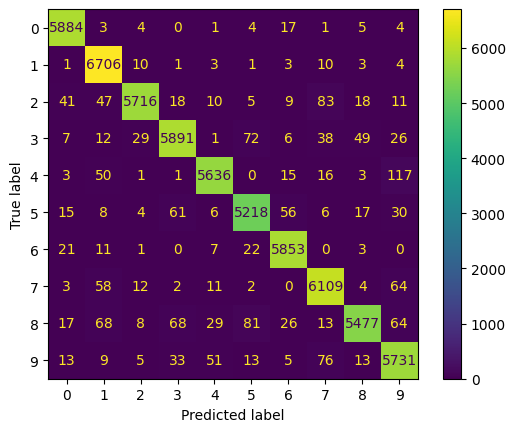

In [61]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

From the confusion matrix above, it looks like the model overall did pretty good predicting images.

5s look like they may have had the most incorrect predictions, with many of the mis-predictions falling on 3 and 6.

We'll also look at this from a normalized view, normalizing over the true conditions (e.g. rows)

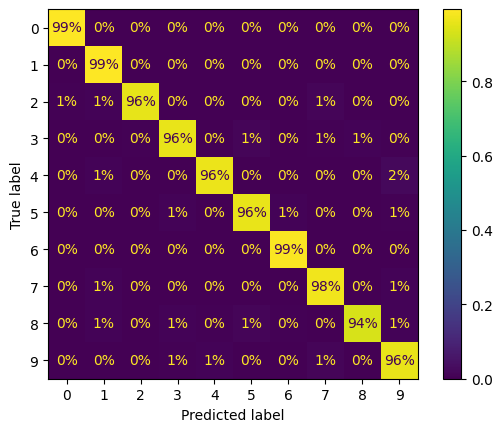

In [66]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%')
plt.show()